# 实验四：朴素贝叶斯分类器
- 姓名：胡博浩
- 学号：2212998
- 专业：信息安全

## 实验要求
### 截止日期：11月10日
作业的提交格式参考之前的说明，提交到雨课堂

### 基本要求
(a)采用分层采样的方式将数据集划分为训练集和测试集 (b)给定编写一个朴素贝叶斯分类器，对测试机进行预测，计算分类准确率

### 中级要求

使用测试机评估模型，得到混淆矩阵、精度、召回率、F值

### 高级要求
在中级要求的基础上画出三类数据的ROC曲线，并求出AUC值

**环境**：conda python 3.9.18 + vscode

代码都进行了适当注释和分析，感谢助教的批阅！辛苦！

---

## 导入需要的包

导入了在数据分析和机器学习中常用的几个库和模块

In [113]:
# 导入需要的包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold # 用于分层交叉验证
from sklearn.preprocessing import label_binarize # 用于将多类标签转换为二值化格式
from scipy.special import softmax # 用于计算softmax函数

## 导入数据集

将数据读取到一个DataFrame中，并使用自定义的列名来组织数据

In [114]:
# 定义特征列名
column_names = [
    'Class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium',
    'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
    'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline'
]

# 读取数据
df = pd.read_csv('./wine.data', header=None, names=column_names)
print(df)

     Class  Alcohol  Malic acid   Ash  Alcalinity of ash  Magnesium  \
0        1    14.23        1.71  2.43               15.6        127   
1        1    13.20        1.78  2.14               11.2        100   
2        1    13.16        2.36  2.67               18.6        101   
3        1    14.37        1.95  2.50               16.8        113   
4        1    13.24        2.59  2.87               21.0        118   
..     ...      ...         ...   ...                ...        ...   
173      3    13.71        5.65  2.45               20.5         95   
174      3    13.40        3.91  2.48               23.0        102   
175      3    13.27        4.28  2.26               20.0        120   
176      3    13.17        2.59  2.37               20.0        120   
177      3    14.13        4.10  2.74               24.5         96   

     Total phenols  Flavanoids  Nonflavanoid phenols  Proanthocyanins  \
0             2.80        3.06                  0.28             2.29   
1

**结果分析**：

数据集包含 178 行和 14 列，其中每行代表一个葡萄酒样本，每列代表一个特征或标签。

## 基本要求

将DataFrame中的特征（除 Class 列外的所有列）和标签（Class 列）分离开来，分别存储在 X 和 y 中

In [115]:
# 分离特征和标签
X = df.drop('Class', axis=1)
y = df['Class']

### 朴素贝叶斯分类器

#### 数学原理及公式

贝叶斯定理描述了后验概率的计算方法：
$ P(C|X) = \frac{P(X|C) \cdot P(C)}{P(X)} $

假设特征 $ X $ 在每个类别 $ C $ 下服从高斯分布，其概率密度函数为：
$ P(X|C) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(X - \mu)^2}{2\sigma^2}\right) $

为了避免数值下溢，代码中使用了对数似然：
$ \log P(X|C) = -\frac{1}{2} \sum \log(2\pi\sigma^2) - \frac{1}{2} \sum \frac{(X - \mu)^2}{\sigma^2} $

#### 代码的关键点

1. **防止除零错误**：在计算方差时，加上一个很小的数 $ 1e-9 $
2. **计算对数后验概率**：在 `calculate_log_proba` 方法中，计算每个样本属于每个类别的对数后验概率。对数后验概率是对数先验概率和对数似然的和。

In [116]:
# 定义朴素贝叶斯分类器
class NaiveBayesClassifier:
    def fit(self, X, y): # 训练模型
        self.classes = np.unique(y) #  存储所有唯一的类标签
        n_samples, n_features = X.shape
        n_classes = len(self.classes)
        
        # 计算每个类的均值、方差和先验概率
        self.mean = np.zeros((n_classes, n_features))
        self.var = np.zeros((n_classes, n_features))
        self.priors = np.zeros(n_classes)
        
        for idx, c in enumerate(self.classes):
            X_c = X[y == c]
            self.mean[idx, :] = X_c.mean(axis=0)
            self.var[idx, :] = X_c.var(axis=0) + 1e-9  # 防止除零
            self.priors[idx] = X_c.shape[0] / float(n_samples)
    
    def predict_log_proba(self, X): # 计算每个样本属于每个类的对数概率
        X = X.values
        return np.array([self._calculate_log_proba(x) for x in X])
    
    def predict(self, X): # 基于对数概率预测每个样本的类标签
        log_proba = self.predict_log_proba(X)
        return self.classes[np.argmax(log_proba, axis=1)]
    
    def _calculate_log_proba(self, x): # 计算给定样本 x 属于每个类的对数后验概率
        log_posteriors = []
        for idx, _ in enumerate(self.classes):
            prior = np.log(self.priors[idx]) # 类的对数先验概率
            likelihood = -0.5 * np.sum(np.log(2 * np.pi * self.var[idx])) # 给定样本在该类下的对数似然
            likelihood -= 0.5 * np.sum(((x - self.mean[idx]) ** 2) / self.var[idx])
            log_posterior = prior + likelihood # 对数后验概率是对数先验概率和对数似然的和
            log_posteriors.append(log_posterior)
        return log_posteriors

### 使用分层采样和十折交叉验证来评估性能
这里我选择使用 StratifiedKFold

In [117]:
# 使用分层采样和十折交叉验证
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) # 这里使用 StratifiedKFold 进行分层采样和十折交叉验证

# 初始化用于存储每个折的准确率、所有真实标签、所有预测结果和所有对数概率的列表
accuracies = []
y_true_all = []
y_pred_all = []
log_proba_all = []

for train_index, test_index in skf.split(X, y): # 这里使用 skf.split(X, y) 生成训练集和测试集的索引
    X_train, X_test = X.iloc[train_index], X.iloc[test_index] # 划分训练集和测试集
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # 训练模型
    clf = NaiveBayesClassifier()
    clf.fit(X_train, y_train)

    # 预测
    y_pred = clf.predict(X_test)
    log_proba = clf.predict_log_proba(X_test)
    y_true = y_test.values

    # 计算准确率
    accuracy = np.mean(y_pred == y_true)
    accuracies.append(accuracy)
    print(f"Fold Accuracy: {accuracy:.4f}")

    # 累积真实标签和预测结果
    y_true_all.extend(y_true)
    y_pred_all.extend(y_pred)
    log_proba_all.extend(log_proba)

# 输出平均准确率
average_accuracy = np.mean(accuracies)
print(f"Average Accuracy: {average_accuracy:.4f}")

Fold Accuracy: 1.0000


Fold Accuracy: 0.8889
Fold Accuracy: 1.0000
Fold Accuracy: 1.0000
Fold Accuracy: 1.0000
Fold Accuracy: 0.9444
Fold Accuracy: 1.0000
Fold Accuracy: 0.9444
Fold Accuracy: 1.0000
Fold Accuracy: 1.0000
Average Accuracy: 0.9778


**结果分析**：

- 平均准确率：模型的平均准确率为 0.9778，说明模型整体上表现良好，能够正确预测大部分样本的分类。

- 单次准确率：每次交叉验证的准确率有所波动，最低为 0.8889，最高为 1.0000。这说明模型的性能在不同折叠的数据上存在一定的差异，可能受到数据分布的影响。

将对数概率转换为概率，并确保标签和预测结果是可以进行数值计算的数组

**关键点：这里使用 softmax 函数将对数概率转换为概率**

softmax 函数会对每个元素进行指数运算，然后除以所有元素的指数和，从而将对数概率转换为概率分布。axis=1 表示在每一行上进行 softmax 计算，适用于多类别分类任务

In [118]:
# 将累积的对数概率转换为概率
log_proba_all = np.array(log_proba_all) # 将列表转换为数组
proba_all = softmax(log_proba_all, axis=1)

# 将标签和预测结果转换为数组
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

## 中级要求

定义一个函数 calculate_metrics，用于计算混淆矩阵以及各类的精确率、召回率和F1分数

TP是真正例，FP是假正例，FN是假反例。

精确率： 精确率是指在所有被预测为正例的样本中，实际为正例的比例。公式如下： $ \text{Precision} = \frac{TP}{TP + FP} $

召回率： 召回率是指在所有实际为正例的样本中，被正确预测为正例的比例。公式如下： $ \text{Recall} = \frac{TP}{TP + FN} $

F1 值： F1 值是精确率和召回率的调和平均数，用于综合评估模型的性能。公式如下： $ F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} $

**注意**：使用条件表达式来避免除零错误

In [119]:
# 计算混淆矩阵
def calculate_metrics(y_true, y_pred, classes):
    conf_matrix = np.zeros((len(classes), len(classes)), dtype=int) # 初始化混淆矩阵
    for i, true_class in enumerate(classes): # 填充混淆矩阵
        for j, pred_class in enumerate(classes):
            conf_matrix[i, j] = np.sum((y_true == true_class) & (y_pred == pred_class))
    
    metrics = {} # 初始化存储指标的字典
    for i, c in enumerate(classes): # 计算每个类的指标
        TP = conf_matrix[i, i] # 真正例
        FP = np.sum(conf_matrix[:, i]) - TP # 假正例
        FN = np.sum(conf_matrix[i, :]) - TP # 假反例
        
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0 # 精确率
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0 # 召回率
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0 # F1 值
        
        metrics[c] = {'precision': precision, 'recall': recall, 'f1': f1} # 存储指标
    
    return conf_matrix, metrics

计算分类模型的混淆矩阵和评估指标，并将结果可视化和打印出来

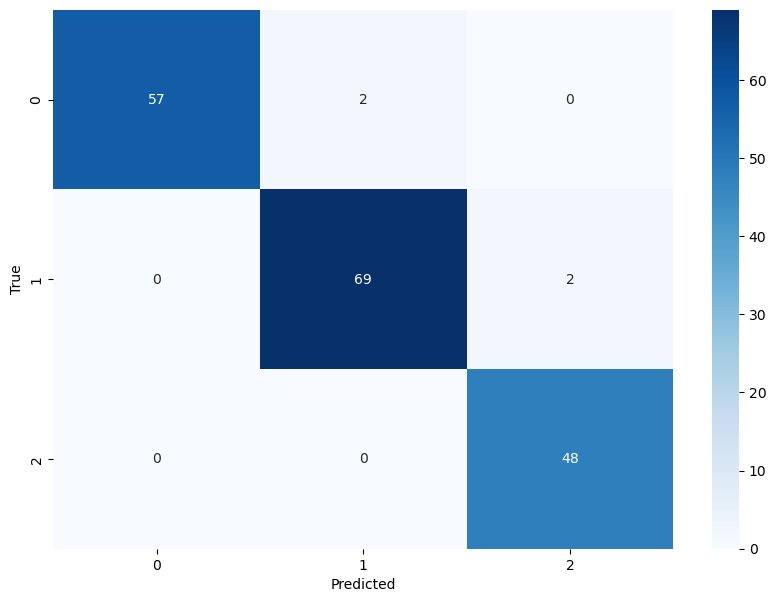


分类评估指标:
   precision    recall        f1
1   1.000000  0.966102  0.982759
2   0.971831  0.971831  0.971831
3   0.960000  1.000000  0.979592
Overall Accuracy: 0.9775


In [124]:
# 计算并绘制混淆矩阵
conf_matrix, metrics = calculate_metrics(y_true_all, y_pred_all, clf.classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 构建表格展示评估指标
print("\n分类评估指标:")
metrics_df = pd.DataFrame(metrics).T
print(metrics_df)

# 打印总体准确率
print(f"Overall Accuracy: {np.trace(conf_matrix) / conf_matrix.sum():.4f}")

**结果分析**：

- 混淆矩阵：模型在三个类别上的预测结果都比较准确，但仍然存在一些误分类的情况。例如，有 2 个 True 1 被误分类为 True 2，有 2 个 True 2 被误分类为 True 3。

- 性能指标：所有类别的精确率、召回率和 F1 值都比较高，说明模型在预测每个类别时都达到了较高的精确性和召回率。

- Overall Accuracy: 0.9775，说明模型整体上能够正确预测大部分样本的分类。

## 高级要求

### ROC曲线和AUC（曲线下面积）
ROC曲线： ROC曲线是用来评估分类模型性能的工具。它通过绘制不同阈值下的真正例率和假正例率来展示模型的表现。

- 真正例率计算公式为： $ TPR = \frac{TP}{P} $ 其中，TP是真正例的数量，P是所有正例的数量。

- 假正例率计算公式为： $ FPR = \frac{FP}{N} $ 其中，FP是假正例的数量，N是所有负例的数量。

AUC： AUC是ROC曲线下的面积，用来量化模型的整体性能。AUC的值介于0和1之间，值越大表示模型性能越好。

- 梯形法则：用于计算曲线下的面积。对于离散点的曲线，可以通过梯形法则近似计算面积。公式为： $ AUC = \sum_{i=1}^{n-1} \frac{(FPR[i] - FPR[i-1]) \times (TPR[i] + TPR[i-1])}{2} $

**注意**：考虑正例和负例数量为零的情况，避免除零错误

In [121]:
# 计算ROC曲线的数据点
def compute_roc_curve(y_true, y_scores):
    thresholds = np.unique(y_scores)[::-1] # 获取所有唯一的分数，并按降序排列
    TPR = []
    FPR = []
    P = np.sum(y_true == 1) # 计算正例和负例的数量
    N = np.sum(y_true == 0)
    
    for thresh in thresholds:
        y_pred = (y_scores >= thresh).astype(int) # 将分数转换为预测标签
        TP = np.sum((y_true == 1) & (y_pred == 1)) # 计算真正例和假正例的数量
        FP = np.sum((y_true == 0) & (y_pred == 1))
        TPR.append(TP / P if P > 0 else 0)
        FPR.append(FP / N if N > 0 else 0)
    
    return FPR, TPR

# 使用梯形法则计算AUC，即ROC曲线下的面积
def compute_auc(fpr, tpr):
    auc = 0.0
    for i in range(1, len(fpr)):
        auc += (fpr[i] - fpr[i-1]) * (tpr[i] + tpr[i-1]) / 2 # 计算梯形面积
    return auc

绘制ROC曲线并计算每个类别的AUC值

**关键点**：
- 将真实标签二值化，以适应ROC曲线的计算要求
- 在图中添加一条对角线作为随机分类器的参考标准

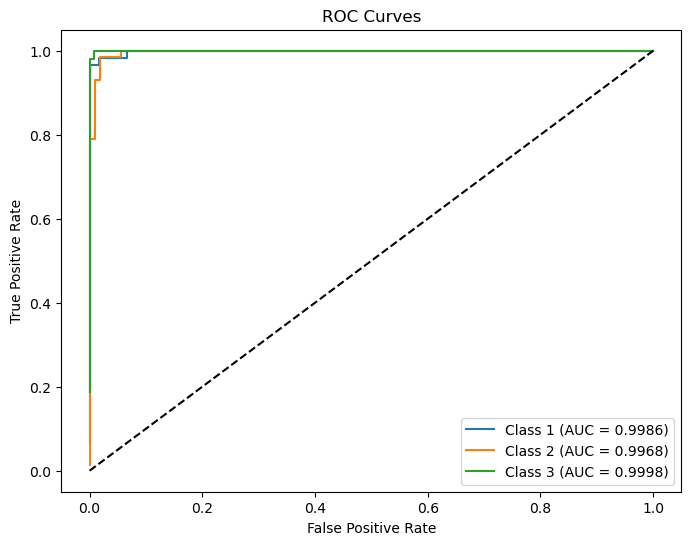

In [122]:
# 二值化标签
classes = np.unique(y) # 获取所有唯一的类标签
y_true_binarized = label_binarize(y_true_all, classes=classes) # 将真实标签y_true_all二值化，转换为一对多的格式

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes): # 枚举每个类别及其索引
    fpr, tpr = compute_roc_curve(y_true_binarized[:, i], proba_all[:, i]) # 计算当前类别的假阳性率（FPR）和真阳性率（TPR）
    roc_auc = compute_auc(fpr, tpr) # 计算当前类别的AUC
    plt.plot(fpr, tpr, label=f'Class {cls} (AUC = {roc_auc:.4f})') # 绘制当前类别的ROC曲线，并在图例中标注AUC值

plt.plot([0, 1], [0, 1], 'k--') # 绘制一条从(0,0)到(1,1)的对角线，作为随机分类器的参考线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()

**结果分析**：

- AUC 值很高：所有类别的 AUC 值都接近 1，说明模型在区分正负样本方面表现非常出色。

- Class 3 的 AUC 值最高：Class 3 的 AUC 值略高于其他两个类别，说明模型对 Class 3 的区分能力略强于其他两个类别。

- ROC 曲线：ROC 曲线接近于左上角，说明模型在不同阈值下都表现良好。